In [14]:
########## Import Libararies
import os
import pickle
import glob
from tqdm.notebook import tqdm

import numpy as np
from skimage import measure
import scipy.ndimage
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline

import open3d as o3d
from compas.geometry import trimesh_remesh
from compas.datastructures import Mesh
import nibabel as nib

# from util import *

import csv
import copy
import pickle
import random


In [15]:
random.seed(42) 
def sub_sort(folder_path):
    file_groups = {}
    
    for filename in os.listdir(folder_path):

        if filename.endswith('.nii.gz'):
            filename = filename[:-7] # .nii.gz elimination
        elif filename.endswith('.npy_L') or filename.endswith('.npy_R'):
            filename = filename[:-6] # .npy_L elimination
        elif filename.endswith('.nii.gz_R') or filename.endswith('.nii.gz_L'):
            filename = filename[:-9] # .npy_L elimination
        elif filename.endswith('_R') or filename.endswith('_L'):
            filename = filename[:-2] # .npy_L eliminations

        # print(filename)
        parts = filename.split('_')
        file_id = '_'.join(map(str, parts[:-5]))
        # print(file_id)
        days = (float(parts[-3]))
        
        # making group by id
        if file_id not in file_groups:
            file_groups[file_id] = []
        
        # filename & days as tuple
        file_groups[file_id].append((filename, days))

    # grouping with same id and sorting by days
    sorted_file_groups = []
    for file_id, files in file_groups.items():
        files_sorted = sorted(files, key=lambda x: x[1])  # x[1]이 days 값
        sorted_file_groups.append([file[0] for file in files_sorted])

    return sorted_file_groups

def get_sub_list(folder_path, ncad = 0):
    files = sub_sort(folder_path)
    file_list, age_list = [], []
    for file in files:
        f = file[0]
        split = f.split("\\")[-1].split("_")
        if split[0].startswith("R"):
            ncad_flag = split[-2]
            age = split[2]
            if int(ncad_flag) == ncad:
                # print(f)
                npy_file = glob.glob(rf"{folder_path}\{f}*\*.npy")
                if npy_file!=[]:
                    loss = float(npy_file[0].split("_")[-1].split(".")[0])
                    # print(loss)
                    if loss <10:
                        if (ncad==0 and float(age)>59 and float(age)<90) or  (ncad==1 and float(age)>59 and float(age)<90) :
                            if ncad==0 and float(age)<73:
                                
                                if random.random()>0.7:
                            
                                    file_list.append(npy_file[0])
                                    age_list.append(float(age))
                            else:
                                file_list.append(npy_file[0])
                                age_list.append(float(age))
    # print(file_list)
    return file_list, age_list


import open3d as o3d
import csv
import glob
import numpy as np
import pickle
import os



tempdata = pickle.load(open(rf"D:\IdeaProjects\longi_node\whole_brain_structure\temp_meshes\cuttail_temp.pkl","rb"))
lvmesh = o3d.geometry.TriangleMesh(vertices=o3d.utility.Vector3dVector(tempdata['cuttail_vert']), triangles=o3d.utility.Vector3iVector(tempdata['lv']))

nc_list, nc_age_list = [], []

ad_list, ad_age_list = [], []
for dataset in ['oasis2', 'oasis3', 'adni', 'aibl']:
    folder = rf"D:\WJ\{dataset}_lv"
    nc, ncage = get_sub_list(folder)
    ad, adage = get_sub_list(folder, ncad = 1)
    nc_list += nc
    nc_age_list += ncage
    ad_list += ad
    ad_age_list += adage
nc_age_list = np.asarray(nc_age_list)
ad_age_list = np.asarray(ad_age_list)
print("NC: mean, std, min, max, sub# : ", np.mean(nc_age_list),np.std(nc_age_list),  np.min(ad_age_list), np.max(nc_age_list), np.shape(nc_age_list))
print("AD: mean, std, min, max, sub# : ", np.mean(ad_age_list),np.std(ad_age_list), np.min(ad_age_list), np.max(ad_age_list), np.shape(ad_age_list))

NC: mean, std, min, max, sub# :  74.27763975155281 6.454599930881587 59.6 89.2 (483,)
AD: mean, std, min, max, sub# :  74.67401960784314 6.667374583953776 59.6 88.8 (204,)


# Generate Average Mesh

In [31]:
modes = ["0627"] #"manual_l", "manual_r","synthseg_l","synthseg_r","synthseg_l_new","synthseg_r_new","synthseg_l_new_2001","synthseg_r_new_2001"]
exclude_list = []

temp_mesh = o3d.geometry.TriangleMesh(vertices=o3d.utility.Vector3dVector(tempdata['cuttail_vert']), triangles=o3d.utility.Vector3iVector(tempdata['lv']))
# output_path = rf"D:\IdeaProjects\IITP_synth\lv-parametric-modelling\ipynb\edinburgh\edinburgh\0124\{mode}\out"
# filelist = glob.glob(rf"{l_save_path}\*.pkl")
# ######### Read Hippo Temp Mesh #########

temp_vert_num = np.asarray(temp_mesh.vertices).shape[0]


# temp_mesh.compute_vertex_normals()
# temp_mesh.paint_uniform_color([0.7, 1.0, 0.7])
count=0
# print(filelist)
index= 0
i_tag=0
filelist = nc_list + ad_list
new_verts = np.empty([len(filelist), temp_vert_num, 3])
for j, key in tqdm(enumerate(filelist)):
    sub = key.split("\\")[-1].split("_")[0]

    with open(key, 'rb') as f:
        Temp_saved = copy.deepcopy(temp_mesh)
        # pcd = o3d.geometry.PointCloud(points=o3d.utility.Vector3dVector(points))
        try:
            # new_vert_file = glob.glob(rf"{output_path}\{sub}\5000*.npy")
            new_vert = np.load(f)[0]
            new_verts[index, :, :] = new_vert
            draw_mesh = copy.deepcopy(temp_mesh)
            draw_mesh.vertices = o3d.utility.Vector3dVector(new_vert)
            draw_mesh.compute_vertex_normals()
            draw_mesh.paint_uniform_color([0.7, 0.7, 1.0])
            index+=1
            # o3d.visualization.draw_geometries([draw_mesh,pcd], mesh_show_wireframe=True)
            # if index>10: break
        except:
            print(sub)

# print(count)
mean_vertices = np.mean(new_verts, axis=0)

avg_mesh = copy.deepcopy(temp_mesh)
if i_tag==0: avg_mesh.vertices = o3d.utility.Vector3dVector(mean_vertices)
mean_vertices =np.asarray(avg_mesh.vertices)
avg_mesh.compute_vertex_normals()
avg_mesh.paint_uniform_color([0.5, 0.5, 1.0])
o3d.visualization.draw_geometries([temp_mesh, avg_mesh], mesh_show_wireframe=True)

colors = np.empty((len(filelist), temp_vert_num, 3))
diffs = np.empty((len(filelist), temp_vert_num, 3))
for i in range(len(filelist)):#len(past_excel.keys())):
    sample = new_verts[i, :, :]
    diffs[i,:,:] =sample - mean_vertices
    # print(np.unique(diffs[i,:,:]))
    colors[i, :, 0] = np.linalg.norm(sample - mean_vertices, axis=1)
    colors[i, :, 1] = np.linalg.norm(sample - mean_vertices, axis=1)
    colors[i, :, 2] = np.linalg.norm(sample - mean_vertices, axis=1)
    # if colors[i, :, 0].mean()>10: print(i) 
var_color = np.var(colors, axis=0)/20


avg_mesh.vertex_colors = o3d.utility.Vector3dVector(var_color)

o3d.visualization.draw_geometries([avg_mesh], mesh_show_wireframe=True)
import matplotlib.pyplot as plt
import numpy as np

# Normalize your value (if not already between 0 and 1)
normalized_value = var_color[:,0]  # Example value, should be between 0 and 1
# print(np.var(colors))

# Get the viridis colormap
viridis = plt.cm.viridis

# Map the normalized value to a color
color = viridis(normalized_value) # Euclidean distance from mean
# print(color.shape)

avg_mesh.vertex_colors = o3d.utility.Vector3dVector(color[:,:3])

# if i_tag==0:o3d.io.write_triangle_mesh(rf"0124_deformity_result/fs-{mode}_avg.obj", avg_mesh)
o3d.visualization.draw_geometries([avg_mesh], mesh_show_wireframe=True)

import numpy as np

# For debugging purposes
# print(np.unique(diffs[0,:,:]))

avg_mesh_normals = np.asarray(avg_mesh.vertex_normals)
viridis = plt.cm.viridis
disps = np.empty((len(filelist), temp_vert_num))
for index, file in tqdm(enumerate(filelist)):
    sub_id = file.split("\\")[-1].split("_")[0]
    # print(colors[index,:,0], sub_id)
    dot_products = np.einsum('ij,ij->i', avg_mesh_normals, diffs[index])
    dot_products[dot_products<0] = -1
    dot_products[dot_products>=0] = 1
    disp = dot_products*colors[index,:,0] # signed Euclidean distance from mean
    #print(disp.shape)
    disps[index]=disp
np.save(f"ncad_R.npy", disps)
        



0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
nc_disps = np.load(f"ncad0.npy")
ad_disps = np.load(f"ncad1.npy")

print(nc_disps.shape, ad_disps.shape, nc_ad_disps.shape)

(410, 2826) (182, 2826) (592, 2826)


In [178]:
print(tempdata.keys())

dict_keys(['cuttail_vert', 'lv', 'hippo'])


In [35]:
from scipy.stats import levene, bartlett, fligner, ttest_ind, shapiro, brunnermunzel
from scipy.stats import mannwhitneyu
from scipy import stats
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
num=299
nc_disps = np.load(f"ncad_R.npy")
p_value = np.zeros(nc_disps.shape[1])
p_data1, p_data2 = [], []
for i in range(nc_disps.shape[1]):
    data1 = nc_disps[:num,i]
    data2 = nc_disps[num:,i]
    # stat_levene, p_levene = fligner(data1, data2)
    stat, p1 = brunnermunzel(data1,data2)
    print(p1)
    p_data1.append(p1)
    
    # if p_levene<0.05:
    #     print(p_levene)
    
    # if p_levene<0.05:
    #     print(p_levene)
    # stat, p = ttest_ind(data1, data2, alternative='two-sided')
    # stat_fligner, p_fligner = fligner(data1, data2)
    # # 1. 정규성 검정 (Shapiro-Wilk)
    # _,shapiro1 = stats.shapiro(data1)
    # _,shapiro2 = stats.shapiro(data2)

    # # 2. 등분산성 검정 (Levene)
    # _,levene_test = stats.levene(data1, data2) 
    p_value[i] = p1
    # print(shapiro1,shapiro2,levene_test)
p_data1 = np.asarray(p_data1)
p_data2 = np.asarray(p_data2)
print(p_data1.shape)
print(p_data2.shape)
print((p_data1>0.05).sum(), (p_data2>0.05).sum())
print((p_data2>0.05).sum())
viridis = plt.cm.hot
color = viridis(p_value*10)
avg_mesh.vertex_colors = o3d.utility.Vector3dVector(color[:,:3])
o3d.io.write_triangle_mesh(rf"brunner.obj", avg_mesh)
# np.save(f"ncad_fligner_p_R.npy", p_value)
o3d.visualization.draw_geometries([avg_mesh], mesh_show_wireframe=True)



0.023223431565145194
0.030632920606309892
0.009056330459073982
0.005493931862416116
0.041229446775081745
0.007586474472927844
0.0287870623394194
0.043285298768356247
0.023805799701971136
0.021303532192983334
0.28911515937194454
0.01732527140442659
0.020062257119192087
0.043033911383346043
0.011134002800668523
0.07197614387928988
0.02008079780612267
0.02391856541658
0.04990246119184612
0.042220872483819
0.06000530152660838
0.041116854257814923
0.00944238159714285
0.012113589019682588
0.010555045554971046
0.002229391217373845
0.0037307852381017956
0.008413769232529605
0.0036279501862568485
0.007351136462237729
0.01390576347497526
0.3902888910626744
0.20940026442718981
0.3694822772940456
0.01418906942421013
0.001927906308431896
0.01064607335723087
0.3343005052968654
0.3637960837716536
0.3922780820757391
0.016263546433906647
0.0032480378439859185
0.011126812327772193
0.010611478886314508
0.014170687144050577
0.0051657870359597
0.004836458582702268
0.34429375092379755
0.2976524393513116
0.0

In [97]:
def sdf_query(mesh, query_points):

  mesh = o3d.t.geometry.TriangleMesh.from_legacy(mesh)

  # Create a scene and add the triangle mesh
  scene = o3d.t.geometry.RaycastingScene()
  _ = scene.add_triangles(mesh)  # we do not need the geometry ID for mesh
  
  sdf = scene.compute_signed_distance(query_points)
  # print(query_points.shape, occupancy.shape)
  # We can visualize a slice of the distance field directly with matplotlib
  # plt.imshow(occupancy.numpy()[:, :, 70])
  #print(np.shape(sdf.numpy()))
  return sdf.numpy()

In [182]:
tempdata = pickle.load(open(rf"D:\IdeaProjects\IITP_synth\lv-parametric-modelling\ipynb\NeuroImg_LVNET\cuttail_temp.pkl","rb"))
tempdata_tex = pickle.load(open(rf"D:\IdeaProjects\IITP_synth\lv-parametric-modelling\ipynb\NeuroImg_LVNET\cuttail_temp_L_tex.pkl","rb"))
print(tempdata_tex.keys())
lv_temp = o3d.geometry.TriangleMesh(vertices=o3d.utility.Vector3dVector(tempdata['cuttail_vert']), triangles=o3d.utility.Vector3iVector(tempdata['lv']))
tri = tempdata_tex['cuttail_lv']
tri0 = tri.copy()
tri0[:,[0,2]] = tri[:,[2,0]]  # swap 0 and 2 to match the original mesh
lv_temp_tex = o3d.geometry.TriangleMesh(vertices=o3d.utility.Vector3dVector(tempdata_tex['cuttail_vert']), triangles=o3d.utility.Vector3iVector(tri0))

mesh1 = o3d.geometry.TriangleMesh(vertices=o3d.utility.Vector3dVector(tempdata_tex['cuttail_vert']), triangles=o3d.utility.Vector3iVector(tempdata_tex['tri1']))
mesh2 = o3d.geometry.TriangleMesh(vertices=o3d.utility.Vector3dVector(tempdata_tex['cuttail_vert']), triangles=o3d.utility.Vector3iVector(tempdata_tex['tri2']))
mesh3 = o3d.geometry.TriangleMesh(vertices=o3d.utility.Vector3dVector(tempdata_tex['cuttail_vert']), triangles=o3d.utility.Vector3iVector(tempdata_tex['tri3']))
mesh4 = o3d.geometry.TriangleMesh(vertices=o3d.utility.Vector3dVector(tempdata['cuttail_vert']), triangles=o3d.utility.Vector3iVector(tempdata['hippo']))
lv_temp.paint_uniform_color([0.7, 0.7, 1.0])
lv_temp_tex.paint_uniform_color([0.7, 1.0, 1.0])
mesh1.paint_uniform_color([1.0, 0.7, 0.7])
mesh2.paint_uniform_color([0.7, 1.0, 0.7])
mesh3.paint_uniform_color([0.7, 0.7, 1.0])
o3d.visualization.draw_geometries([mesh1,mesh2,mesh3, mesh4], mesh_show_wireframe=True)



dict_keys(['cuttail_vert', 'cuttail_lv', 'cuttail_hippo', 'tri1', 'tri2', 'tri3'])


In [9]:
verts = np.asarray(tempdata['cuttail_vert']).astype(np.float32)
print(verts.shape)
mesh1_sdf = np.abs(sdf_query(mesh1, verts))
mesh2_sdf = np.abs(sdf_query(mesh2, verts))
mesh3_sdf = np.abs(sdf_query(mesh3, verts))
mesh4_sdf = np.abs(sdf_query(mesh4, verts))
print(mesh1_sdf.shape, mesh1_sdf[:5])

# index of mesh1_sdf<0.01
index1 = np.where(mesh1_sdf<0.05)[0]
index2 = np.where(mesh2_sdf<0.05)[0]
index3 = np.where(mesh3_sdf<0.05)[0]
index4 = np.where(mesh4_sdf<0.05)[0]
# N,3 size data to N*3 size data

print(index4)
print(index4.shape)
print(index1.shape, index1[:5])
tri1, tri2, tri3, tri4 = [], [], [], []
for i in range(tempdata['lv'].shape[0]):

        if (tempdata['lv'][i,0] in index1) and (tempdata['lv'][i,1] in index1) and (tempdata['lv'][i,2] in index1):
            tri1.append(tempdata['lv'][i].tolist())
        elif (tempdata['lv'][i,0] in index2) and (tempdata['lv'][i,1] in index2) and (tempdata['lv'][i,2] in index2):
            tri2.append(tempdata['lv'][i].tolist())
        elif (tempdata['lv'][i,0] in index3) and (tempdata['lv'][i,1] in index3) and (tempdata['lv'][i,2] in index3):
            tri3.append(tempdata['lv'][i].tolist())
        elif (tempdata['lv'][i,0] in index4) and (tempdata['lv'][i,1] in index4) and (tempdata['lv'][i,2] in index4):
            tri4.append(tempdata['lv'][i].tolist())
tri1 = np.asarray((tri1))
print(tri1.shape)
tri2 = np.asarray((tri2))
print(tri2.shape)
tri3 = np.asarray((tri3))
print(tri3.shape)
tri4 = np.asarray((tri4))
print(tri4.shape)

mesh1 = o3d.geometry.TriangleMesh(vertices=o3d.utility.Vector3dVector(tempdata['cuttail_vert']), triangles=o3d.utility.Vector3iVector(tri1))
mesh2 = o3d.geometry.TriangleMesh(vertices=o3d.utility.Vector3dVector(tempdata['cuttail_vert']), triangles=o3d.utility.Vector3iVector(tri2))
mesh3 = o3d.geometry.TriangleMesh(vertices=o3d.utility.Vector3dVector(tempdata['cuttail_vert']), triangles=o3d.utility.Vector3iVector(tri3))
mesh4 = o3d.geometry.TriangleMesh(vertices=o3d.utility.Vector3dVector(tempdata['cuttail_vert']), triangles=o3d.utility.Vector3iVector(tri4))
mesh1.paint_uniform_color([1.0, 0.7, 0.7])
mesh2.paint_uniform_color([0.7, 1.0, 0.7])
mesh3.paint_uniform_color([0.7, 0.7, 1.0])
mesh4.paint_uniform_color([0.7, 0.85, 0.8])
        
o3d.visualization.draw_geometries([mesh1,mesh2,mesh3,mesh4], mesh_show_wireframe=True)



(2826, 3)


NameError: name 'sdf_query' is not defined

In [156]:
print(tempdata_tex['cuttail_lv'].max())
print(tempdata_tex['cuttail_hippo'].min())

2489
334


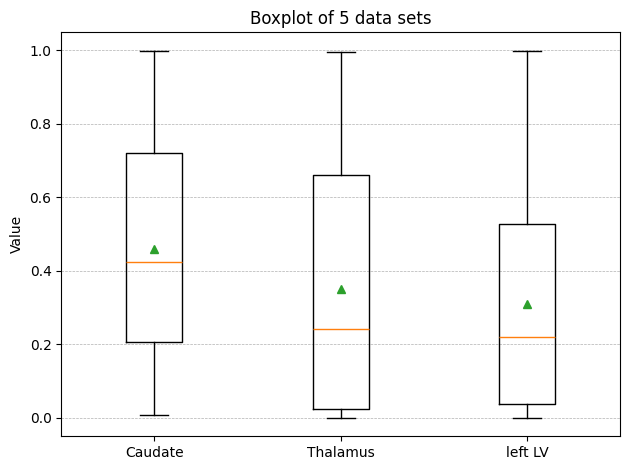

In [185]:
p_all = []


for index in [index1, index2]: # caudate, thalamus, opposite LV
    
    p_all.append(p_value[index])
p_all.append(p_value)
plt.boxplot(
    p_all,
    vert=True,              # vertical boxes (set False for horizontal)
    labels=['Caudate', 'Thalamus', 'left LV'],
    showmeans=True          # draws a green triangle at the mean
)

plt.ylabel("Value")
plt.title("Boxplot of 5 data sets")
plt.grid(axis="y", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

